In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.append('..')

import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np

from qpu_layers import *
from train_utils import train, evaluate
from cube_edge import CubeEdge
from models import QMLP, QMLP_RInv, RMLP

In [3]:
def plot(data, title, log_dir, labels):
    num_curves = len(data)
    fig = plt.figure(title)
    for i in range(num_curves):
        fig.gca().plot(data[i], label=labels[i])
    fig.gca().legend()
    fig.savefig(os.path.join(log_dir, '.'.join([title, 'png'])))


def train_edge(net, train_epoch, num_edges, num_samples, random_rotation, use_quaternion):
    train_data = CubeEdge(train=True, num_edges=num_edges, num_samples=num_samples, random_rotation=random_rotation, use_quaternion=use_quaternion)
    test_data = CubeEdge(train=False, num_edges=num_edges, num_samples=200, random_rotation=random_rotation, use_quaternion=use_quaternion, sigma=0.1)
    train_loss, eval_loss, train_acc, eval_acc = train(net, train_data, test_data, lr=1e-3, num_epochs=train_epoch, 
                                                       batch_size=200, print_loss=False)
    return train_loss, eval_loss, train_acc, eval_acc


def eval_edge(net, num_edges, num_samples, random_rotation, use_quaternion, sigma):
    test_data = CubeEdge(train=False, num_edges=num_edges, num_samples=num_samples, random_rotation=random_rotation, 
                        use_quaternion=use_quaternion, sigma=sigma)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=200, shuffle=False, num_workers=1)
    loss, acc = evaluate(net, test_loader, torch.nn.CrossEntropyLoss(), num_cls=test_data.num_shapes)
    return loss, acc

In [4]:
### Train QMLP, QMLP_RInv and RMLP models on CubeEdge dataset

In [5]:
num_edges = 7
num_samples=2000
train_epoch=100
train_data = CubeEdge(train=True, num_edges=num_edges, num_samples=num_samples, random_rotation=False, use_quaternion=True)
num_cls = train_data.num_shapes

# QMLP
qmlp = QMLP(num_data=num_edges, num_cls=num_cls)
train_loss_qmlp, _, _, _ = train_edge(net=qmlp, train_epoch=train_epoch, num_edges=num_edges, num_samples=num_samples, 
                                    random_rotation=False, use_quaternion=True)
# QMLP RInv
qmlp_rinv = QMLP_RInv(num_data=num_edges, num_cls=num_cls, in_channel=4)
train_loss_qmlp_rinv, _, _, _ = train_edge(net=qmlp_rinv, train_epoch=train_epoch, num_edges=num_edges, num_samples=num_samples, 
                                    random_rotation=False, use_quaternion=True)
# RMLP
rmlp = RMLP(num_data=num_edges, num_cls=num_cls, in_channel=4)
train_loss_rmlp, _, _, _ = train_edge(net=rmlp, train_epoch=train_epoch, num_edges=num_edges, num_samples=num_samples, 
                                    random_rotation=False, use_quaternion=True)

QMLP(
  (mlp): Sequential(
    (0): QPU(in_features=7, out_features=32, bias=True)
    (1): QPU(in_features=32, out_features=32, bias=True)
    (2): Linear(in_features=128, out_features=32, bias=True)
  )
)
Finish training, time 905.135
QMLP_RInv(
  (mlp): Sequential(
    (0): QPU(in_features=7, out_features=32, bias=True)
    (1): QPU(in_features=32, out_features=128, bias=True)
    (2): KeepRealPart(dim=-1)
    (3): Linear(in_features=128, out_features=32, bias=True)
  )
)
Finish training, time 928.244
RMLP(
  (mlp): Sequential(
    (0): Linear(in_features=28, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=32, bias=True)
  )
)
Finish training, time 912.812


### Plot training loss

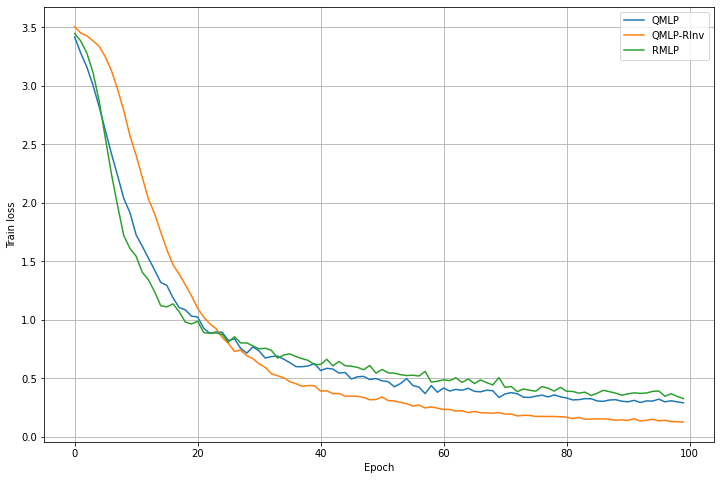

In [6]:
# Plot loss
fig_loss = plt.figure(figsize=[12, 8])
ax=fig_loss.gca()
ax.plot(train_loss_qmlp, label='QMLP')
ax.plot(train_loss_qmlp_rinv, label='QMLP-RInv')
ax.plot(train_loss_rmlp, label='RMLP')
ax.set_xlabel("Epoch")
ax.set_ylabel("Train loss")
ax.legend()
ax.grid(True)

In [7]:
### Test three trained models under different noise levels

In [8]:
acc_qmlp_list={True: [], False: []}
acc_qmlp_rinv_list={True: [], False: []}
acc_rmlp_list={True: [], False: []}
simga_samples = 20
sigma_list = np.linspace(0, 0.5, simga_samples)

for rotate in [True, False]:
    print('Test rotation: ', rotate)
    for i in range(simga_samples):
        # QMLP
        _, acc_qmlp = eval_edge(qmlp, num_edges=num_edges, num_samples=num_samples, random_rotation=rotate, use_quaternion=True, sigma=sigma_list[i])
        acc_qmlp_list[rotate].append(acc_qmlp)
        # QMLP RInv
        _, acc_qmlp_rinv = eval_edge(qmlp_rinv, num_edges=num_edges, num_samples=num_samples, random_rotation=rotate, use_quaternion=True, sigma=sigma_list[i])
        acc_qmlp_rinv_list[rotate].append(acc_qmlp_rinv)
        # RMLP
        _, acc_rmlp = eval_edge(rmlp, num_edges=num_edges, num_samples=num_samples, random_rotation=rotate, use_quaternion=True, sigma=sigma_list[i])
        acc_rmlp_list[rotate].append(acc_rmlp)
        print('Sigma: {:.4f}, QMLP acc: {:.4f}, QMLP-RInv acc: {:.4f}, RMLP acc {:.4f}'.format(sigma_list[i], acc_qmlp, acc_qmlp_rinv, acc_rmlp))

Test rotation:  True
Sigma: 0.0000, QMLP acc: 0.2965, QMLP-RInv acc: 0.9740, RMLP acc 0.1100
Sigma: 0.0263, QMLP acc: 0.2920, QMLP-RInv acc: 0.9730, RMLP acc 0.1100
Sigma: 0.0526, QMLP acc: 0.2875, QMLP-RInv acc: 0.9625, RMLP acc 0.1100
Sigma: 0.0789, QMLP acc: 0.2870, QMLP-RInv acc: 0.9490, RMLP acc 0.1070
Sigma: 0.1053, QMLP acc: 0.2795, QMLP-RInv acc: 0.9340, RMLP acc 0.1065
Sigma: 0.1316, QMLP acc: 0.2730, QMLP-RInv acc: 0.9205, RMLP acc 0.1065
Sigma: 0.1579, QMLP acc: 0.2645, QMLP-RInv acc: 0.9035, RMLP acc 0.1060
Sigma: 0.1842, QMLP acc: 0.2625, QMLP-RInv acc: 0.8845, RMLP acc 0.1050
Sigma: 0.2105, QMLP acc: 0.2520, QMLP-RInv acc: 0.8620, RMLP acc 0.1050
Sigma: 0.2368, QMLP acc: 0.2475, QMLP-RInv acc: 0.8385, RMLP acc 0.1005
Sigma: 0.2632, QMLP acc: 0.2395, QMLP-RInv acc: 0.8135, RMLP acc 0.0995
Sigma: 0.2895, QMLP acc: 0.2345, QMLP-RInv acc: 0.7770, RMLP acc 0.0960
Sigma: 0.3158, QMLP acc: 0.2225, QMLP-RInv acc: 0.7450, RMLP acc 0.0935
Sigma: 0.3421, QMLP acc: 0.2140, QMLP-RInv 

### Plot testing accuracy

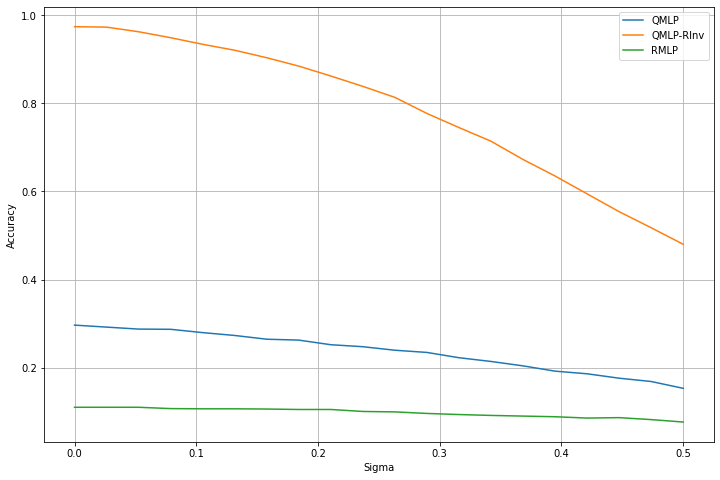

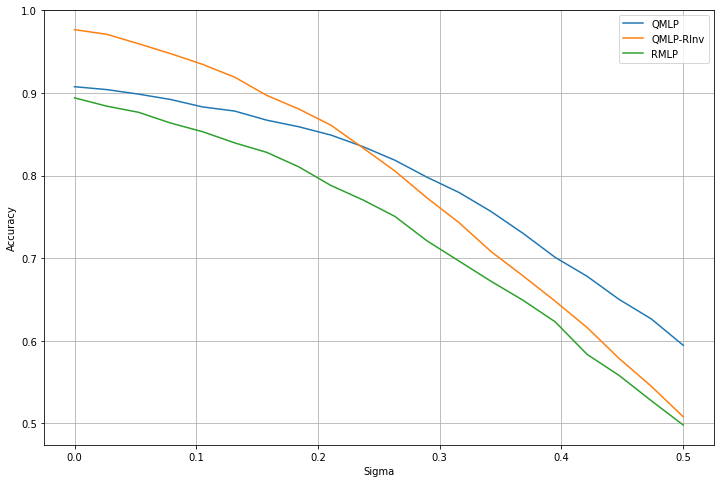

In [9]:
for rotate in [True, False]:
    fig_acc = plt.figure(figsize=[12, 8])
    ax=fig_acc.gca()
    ax.plot(sigma_list, acc_qmlp_list[rotate], label='QMLP')
    ax.plot(sigma_list, acc_qmlp_rinv_list[rotate], label='QMLP-RInv')
    ax.plot(sigma_list, acc_rmlp_list[rotate], label='RMLP')
    ax.set_xlabel("Sigma")
    ax.set_ylabel("Accuracy")
    ax.legend()
    ax.grid(True)